# Zadanie: pozostałe metryki

In [25]:
#podstawowe importy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [26]:
#wczytanie danych i podstawowe przekształcenia
bike_data_raw = pd.read_csv('daily-bike-share.csv')
bike_data_raw['dteday'] = pd.to_datetime(bike_data_raw['dteday'])

bike_data = bike_data_raw.copy()
bike_data.drop(['instant', 'dteday', 'yr'], axis=1, inplace=True)


In [27]:
# kategoryzacja cech i dodatkowe przekształcenia
categorical_features = ['season','mnth','holiday','weekday','workingday','weathersit']
target = 'rentals'
bike_data['difference_temp'] = (bike_data['atemp'] - bike_data['temp'])/bike_data['temp']
bike_data.drop(['atemp'], axis=1, inplace=True)
numeric_features = ['temp', 'difference_temp', 'hum', 'windspeed']

## Pierwszy model - regresja liniowa

In [28]:
# X i y
X = bike_data[['temp']].copy()
y = bike_data[target].copy()

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression() # inicjalizacja modelu
lr_model.fit(X_train, y_train) # trenowanie modelu


LinearRegression()

In [32]:
y_predict_train = lr_model.predict(X_train)
y_predict_test = lr_model.predict(X_test)

### Metryki - pierwszy model

In [39]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from math import sqrt


print(f'R^2: {r2_score(y_test, y_predict_test)}')
print(f'MAE: {mean_absolute_error(y_test, y_predict_test)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_predict_test)}')
print(f'MSE: {mean_squared_error(y_test, y_predict_test)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_predict_test))}')

Test R^2: 0.19412301357953676


In [47]:
# do późniejszego porównania w jednym miejscu
data=[r2_score(y_test, y_predict_test),
    mean_absolute_error(y_test, y_predict_test),
    mean_absolute_percentage_error(y_test, y_predict_test),
    mean_squared_error(y_test, y_predict_test),
    sqrt(mean_squared_error(y_test, y_predict_test))]
compare_df = pd.DataFrame(data, columns=['Pierwszy model'], index=['R^2','MAE','MAPE','MSE','RMSE'])

m1_y_predict_test = y_predict_test.copy()
m1_y_test = y_test.copy()

Porównanie wartości prawdziwej z predykcją

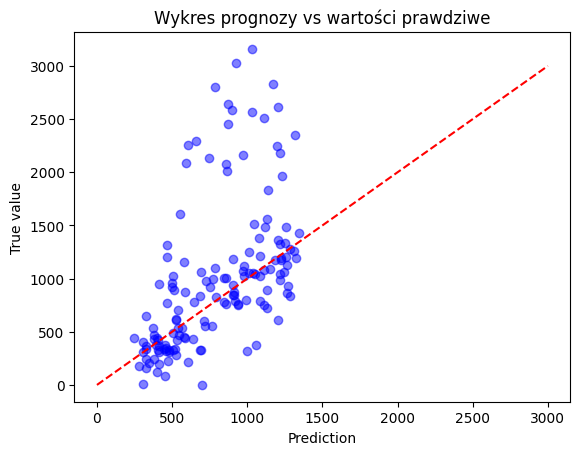

In [48]:
X_linspace = np.linspace(0, 3000, 3000)

plt.scatter(m1_y_predict_test, m1_y_test, color='blue', alpha=0.5)
plt.plot(X_linspace, X_linspace, linestyle='dashed', color='red')
plt.title('Wykres prognozy vs wartości prawdziwe')
plt.xlabel("Prediction")
plt.ylabel("True value")

plt.show()

## Ostatni model - wykorzystanie zmiennych kategorycznych

In [53]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, shuffle=False)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

# Podział na zmienne objaśniające i zmienną objaśnianą
X = bike_data[numeric_features+categorical_features].copy()
y = bike_data[target].copy()

# Podział na zbiór treningowy i testowy (taki sam podział co poprzednio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
numeric_transformer = Pipeline(steps=[
    ('logtransformer', PowerTransformer()),
    ('standardscaler', StandardScaler()),
    ('polynomialfeatures', PolynomialFeatures())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Tworzenie końcowego Pipeline, który będziemy trenować
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', ElasticNet())])

params = {'preprocessor__num__polynomialfeatures__degree': [1, 2, 3, 4, 5],
          'regressor__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
          'regressor__l1_ratio': np.arange(0, 1.1, 0.1)}

final_polynomial_regression_gridsearch = GridSearchCV(final_pipeline,
                                                      params,
                                                      scoring='neg_mean_squared_error',
                                                      cv=cv)

final_polynomial_regression_gridsearch.fit(X_train, y_train)
print("\nNajlepsze hiperparametry:", final_polynomial_regression_gridsearch.best_params_, "\n")

final_polynomial_regression_model = final_polynomial_regression_gridsearch.best_estimator_
predictions = final_polynomial_regression_model.predict(X_test)

c:\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.169e+07, tolerance: 2.207e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.884e+07, tolerance: 2.268e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ri


Najlepsze hiperparametry: {'preprocessor__num__polynomialfeatures__degree': 1, 'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.4} 

RMSE: 483.93794140501114


### Metryki - ostatni model

In [54]:
print(f'R^2: {r2_score(y_test, predictions)}')
print(f'MAE: {mean_absolute_error(y_test, predictions)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, predictions)}')
print(f'MSE: {mean_squared_error(y_test, predictions)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, predictions))}')

R^2: 0.5246818862090765
MAE: 348.5851935515566
MAPE: 0.8593319730028237
MSE: 234195.93113132
RMSE: 483.93794140501114


In [56]:
# do późniejszego porównania w jednym miejscu
data2=[r2_score(y_test, predictions),
    mean_absolute_error(y_test, predictions),
    mean_absolute_percentage_error(y_test, predictions),
    mean_squared_error(y_test, predictions),
    sqrt(mean_squared_error(y_test, predictions))]
compare_df['Ostatni model'] = data2


Porównanie wartości prawdziwej z predykcją

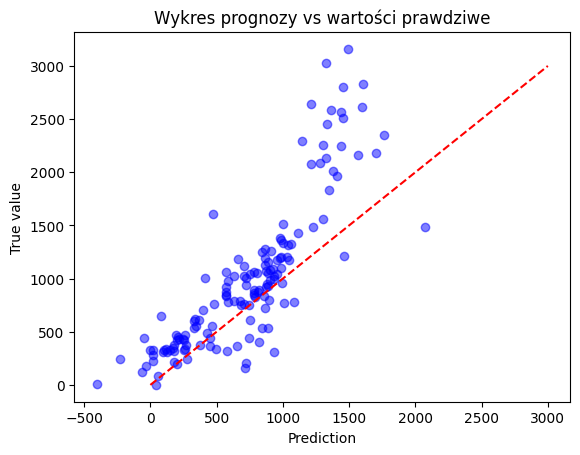

In [80]:
plt.scatter(predictions, y_test, color='blue', alpha=0.5)
plt.plot(X_linspace, X_linspace, linestyle='dashed', color='red')
plt.title('Wykres prognozy vs wartości prawdziwe')
plt.xlabel("Prediction")
plt.ylabel("True value")

plt.show()

## Porównanie modeli

[Text(0.5, 0, 'Prediction')]

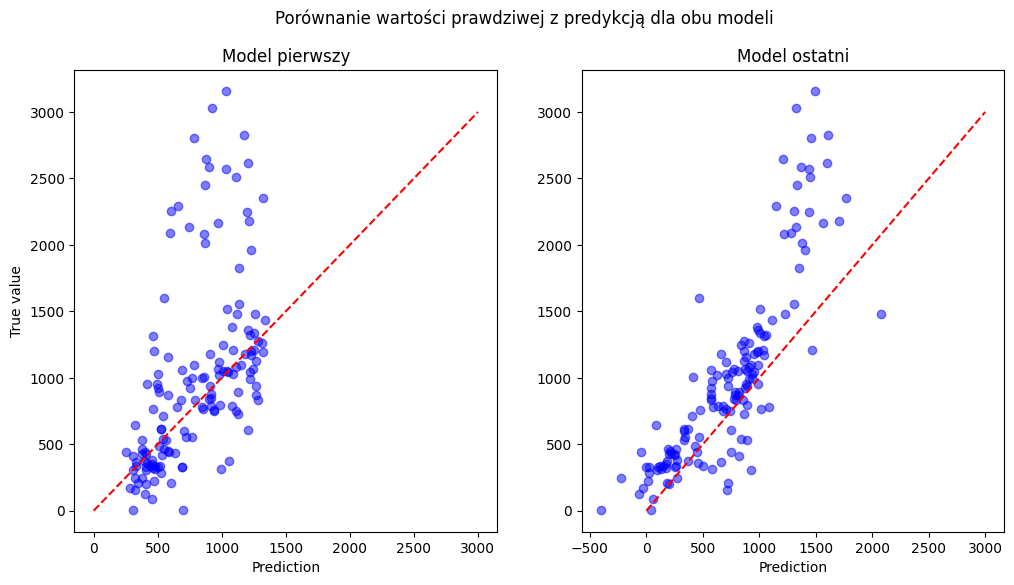

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle('Porównanie wartości prawdziwej z predykcją dla obu modeli')

ax1.scatter(m1_y_predict_test, m1_y_test, color='blue', alpha=0.5)
ax1.plot(X_linspace, X_linspace, linestyle='dashed', color='red')
ax1.set_title('Model pierwszy')

ax2.scatter(predictions, y_test, color='blue', alpha=0.5)
ax2.plot(X_linspace, X_linspace, linestyle='dashed', color='red')
ax2.set_title('Model ostatni')

ax1.set(xlabel='Prediction', ylabel='True value')
ax2.set(xlabel='Prediction')

[Text(0.5, 0, 'True Valuey_test')]

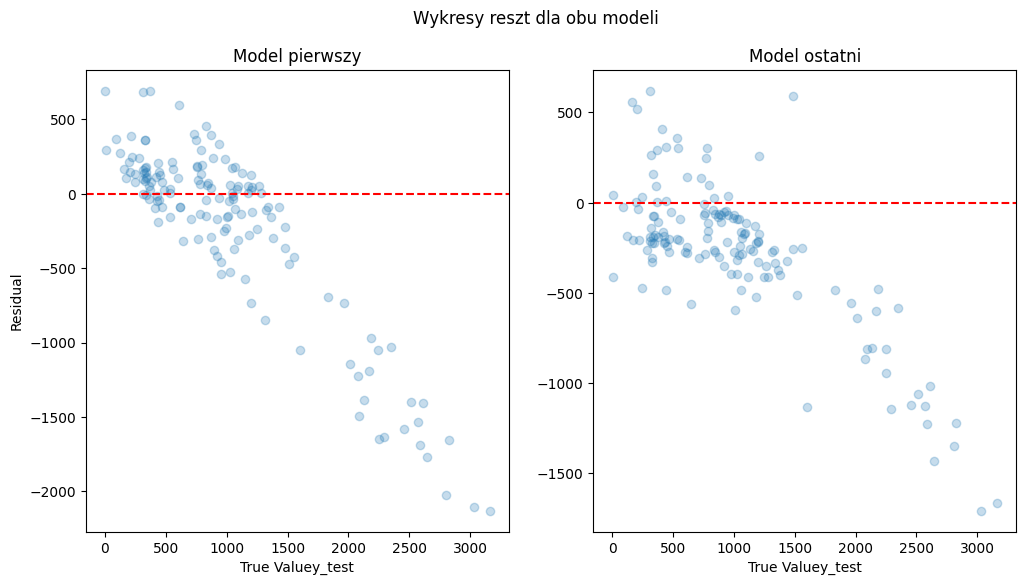

In [75]:
m1_errors = m1_y_predict_test - m1_y_test
errors = predictions - y_test

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle('Wykresy reszt dla obu modeli')

ax1.scatter(x = m1_y_test, y = m1_errors, alpha=0.25)
ax1.axhline(0, color="r", linestyle="--")
ax1.set_title('Model pierwszy')

ax2.scatter(x = y_test, y = errors, alpha=0.25)
ax2.axhline(0, color="r", linestyle="--")
ax2.set_title('Model ostatni')

ax1.set(xlabel='True Valuey_test', ylabel='Residual')
ax2.set(xlabel='True Valuey_test')

Text(0.5, 1.0, 'Model ostatni - średnia błędów = -269.8')

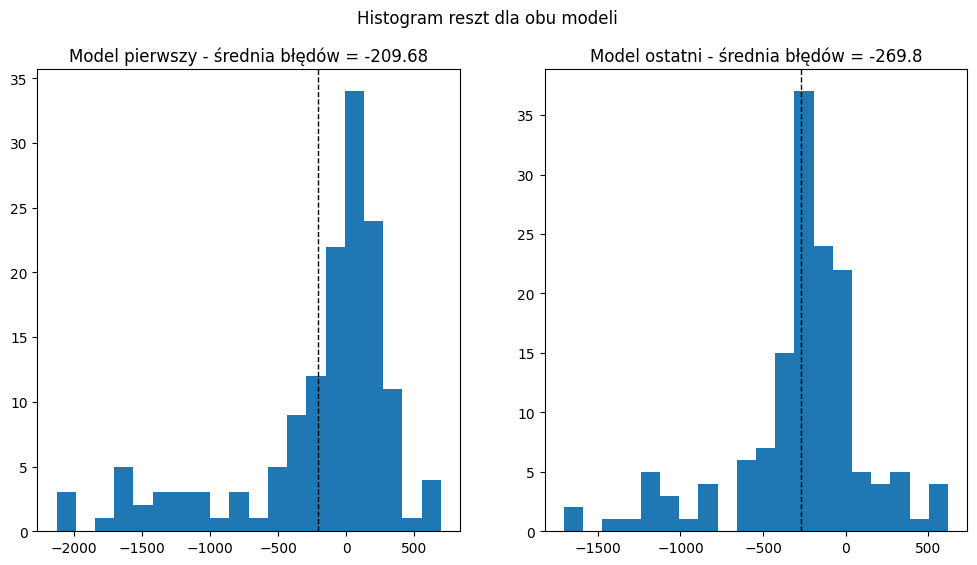

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle('Histogram reszt dla obu modeli')

ax1.hist(m1_errors, bins = 20)
ax1.axvline(m1_errors.mean(), color='k', linestyle='dashed', linewidth=1)
ax1.set_title(f'Model pierwszy - średnia błędów = {np.round(m1_errors.mean(), 2)}')

ax2.hist(errors, bins = 20)
ax2.axvline(errors.mean(), color='k', linestyle='dashed', linewidth=1)
ax2.set_title(f'Model ostatni - średnia błędów = {np.round(errors.mean(), 2)}')

In [78]:
compare_df

,Pierwszy model,Ostatni model
R^2,0.194123,0.524682
MAE,391.028794,348.585194
MAPE,2.986493,0.859332
MSE,397066.944718,234195.931131
RMSE,630.132482,483.937941


In [79]:
print('R^2 większe dla modelu ostatniego, jest on lepiej dopasowany (wartość bliższa 1).')
print('MAE mniejsze dla modelu ostatniego, osiągnięto lepszy średni błąd absolutny.')
print('MAPE mniejsze dla modelu ostatniego, osiągnięto dużo lepszy średni błąd procentowy.')
print('MSE mniejsze dla modelu ostatniego, osiągnięto lepszy średni błąd kwadratowy.')
print('RMSE mniejsze dla modelu ostatniego, osiągnięto lepszy pierwiastek błędu średniokwadratowego (co zresztą wynika z MSE).')

print('Model ostatni osiągnął lepsze wyniki.')

R^2 większe dla modelu ostatniego, jest on lepiej dopasowany (wartość bliższa 1).
MAE mniejsze dla modelu ostatniego, osiągnięto lepszy średni błąd absolutny.
MAPE mniejsze dla modelu ostatniego, osiągnięto dużo lepszy średni błąd procentowy.
MSE mniejsze dla modelu ostatniego, osiągnięto lepszy średni błąd kwadratowy.
RMSE mniejsze dla modelu ostatniego, osiągnięto lepszy pierwiastek błędu średniokwadratowego (co zresztą wynika z MSE).
Model ostatni osiągnął lepsze wyniki.
